# Notebook 1 - Simulation

In this notebook we use `harissa` to simulate a basic repressilator network with 3 genes (1 ⇥ 2 ⇥ 3 ⇥ 1).

In [1]:
import numpy as np
from harissa import NetworkModel, NetworkParameter
from harissa.simulation import ApproxODE, BurstyPDMP

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Model definition

We start by initializing the dynamical model and set the network interactions.

In [2]:
param = NetworkParameter(3)
# Basal gene activities
param.basal[1] = 5
param.basal[2] = 5
param.basal[3] = 5
# Inhibitions in cycle
param.interaction[1,2] = -10
param.interaction[2,3] = -10
param.interaction[3,1] = -10

# Degradation rates (per unit of time)
param.degradation_rna[:] = 1.0
param.degradation_protein[:] = 0.2

# Creation rates
param.creation_rna[:] = param.degradation_rna * param.scale() 
param.creation_protein[:] = param.degradation_protein * param.scale()

model = NetworkModel(param)

In [3]:
param_dict = {
    'burst_frequency_min': param.burst_frequency_min,
    'burst_frequency_max': param.burst_frequency_max,
    'burst_size_inv': param.burst_size_inv,
    'creation_rna': param.creation_rna,
    'creation_protein': param.creation_protein,
    'degradation_rna': param.degradation_rna,
    'degradation_protein': param.degradation_protein,
    'basal': param.basal,
    'interaction': param.interaction 
}
# np.savez('network_param', **param_dict)

## First simulation

We can now simulate and plot a trajectory for one single cell. Some critical parameters of the dynamical model are the degradation rates $d_0$ and $d_1$ which characterize the ‘responsiveness’ of mRNA and protein levels. Note that the `harissa.simulation` module is not based on time discretization and always returns exact stochastic simulations: the resulting continuous-time trajectories are simply extracted at user-specified time points.

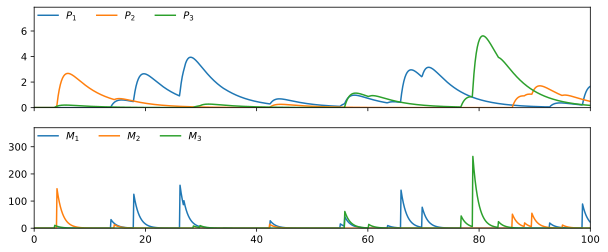

In [4]:
from harissa.graphics import plot_simulation

# Set required time points
time = np.linspace(0,100,1000)
# np.savez('simulation_param', time_points=time)

# Compute exact simulation
sim = model.simulate(time)

plot_simulation(sim).show(warn=False)

Here the ratio $d_0/d_1 \approx 5$ is biologically relevant. Note that despite the strong level of stochasticity, a robust periodic pattern is already emerging.

## Simulation with more stable proteins

More stable proteins – with respect to mRNA – will lead to less ‘intrinsic noise’ in the system. Here we increase the mRNA degradation rates instead, which is equivalent to a zoom-out regarding the time scale. Note that mRNA and protein scales are normalized so the overall levels do not depend on degradation rates (but the *dynamics* does).

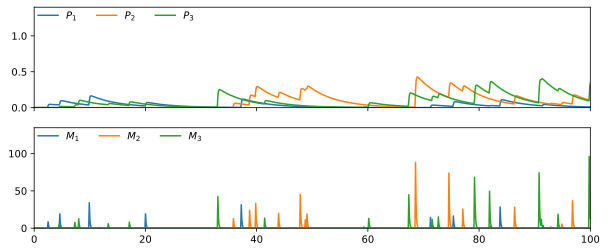

In [5]:
# mRNA degradation rate
param.degradation_rna[:] = 10.0
param.creation_rna[:] = param.degradation_rna * param.scale()
 
# Compute exact simulation
sim = model.simulate(time)
# Plot the simulation
plot_simulation(sim).show(warn=False)

The emerging periodic pattern is now more visible.

## Even more stable proteins

Let us try with even more stable proteins ($d_0/d_1 \approx 250$).

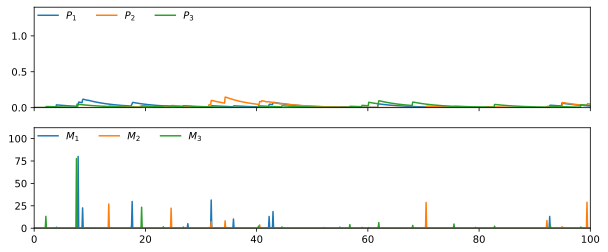

In [6]:
# The simulation may take longer as we zoom-out
param.degradation_rna[:] = 50.0
param.creation_rna[:] = param.degradation_rna * param.scale()

# Compute exact simulation
sim = model.simulate(time)
# Plot the simulation
plot_simulation(sim).show(warn=False)

The system is now approaching a ‘slow-fast’ limit where proteins follow deterministic dynamics. Note that mRNA levels start to follow a quasi-steady-state (QSS) distribution and become *independent conditionally on protein levels* such that $M_i(t) \sim \mathrm{Gamma}(k_{\mathrm{on},i}(P(t))/d_{0,i},b_i)$ for $i=1,2,3$.

## Deterministic limit

At the limit $d_0/d_1 \to \infty$, the stochastic model converges towards a nonlinear ODE system involving only proteins. Note that in this deterministic regime, the initial protein levels need to be perturbed so as not to stay in a trivial manifold.

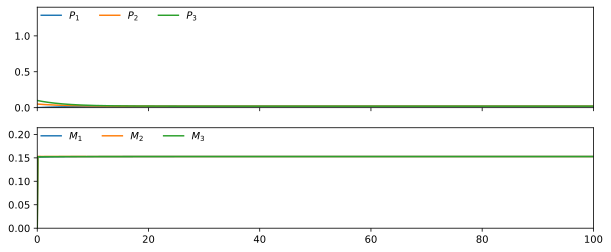

In [7]:
# Deterministic model (slow-fast limit)
model.simulation = ApproxODE()
# Plot the simulation
initial_state =np.array([[0.0, 0.0, 0.0, 0.0], 
                         [1.0, 0.0, 0.05, 0.1]])
# np.savez('simulation_param_ode', time_points=time, initial_state=initial_state)
plot_simulation(model.simulate(time, initial_state=initial_state)).show(warn=False)

Regarding mRNA levels, the `simulate_ode` method only returns the *mean* of the quasi-steady-state distribution conditionally on protein levels (the true limit model would consist in sampling $M_i(t) \sim \mathrm{Gamma}(k_{\mathrm{on},i}(P(t))/d_{0,i},b_i$) independently for every $t > 0$).

## Final remark

It is of course possible to set specific mRNA and protein degradation rates for each gene.

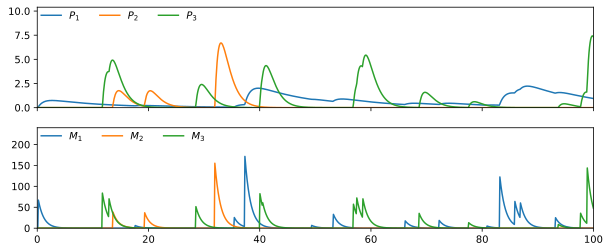

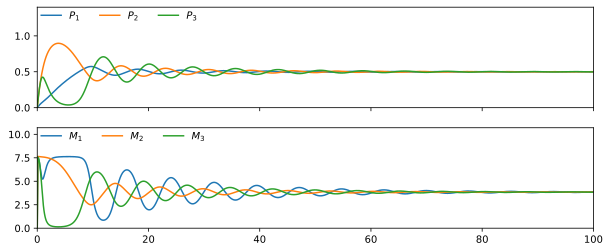

In [8]:
# Ignore degradation_rna[0] and degradation_protein[0] (gene 0 = stimulus)
param.degradation_rna[1:] = [1, 1, 1]
param.degradation_protein[1:] = [0.1, 0.8, 0.85]

param.creation_rna[:] = param.degradation_rna * param.scale()
param.creation_protein[:] = param.degradation_protein * param.scale()

simulations = [
    BurstyPDMP(), # Stochastic model
    ApproxODE(), # Deterministic model
]

for simulation in simulations:
    model.simulation = simulation
    plot_simulation(model.simulate(time)).show(warn=False)


...Degradation rates are crucial parameters of the dynamical model.

## Burn-in

[[0.00000000e+00 5.01893469e-03 2.05808474e+01 4.25589086e-01]
 [1.00000000e+00 9.87513739e-02 1.53646135e+00 1.57934454e-01]]


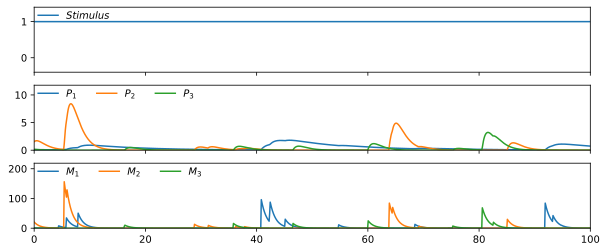

In [9]:
model.simulation = simulations[0]
burn_in_state = model.burn_in(10.0)

print(burn_in_state)

plot_simulation(model.simulate(time, initial_state=burn_in_state), True).show(warn=False)

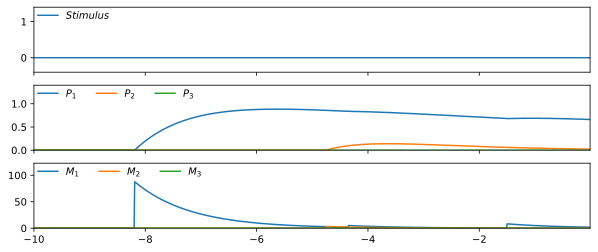

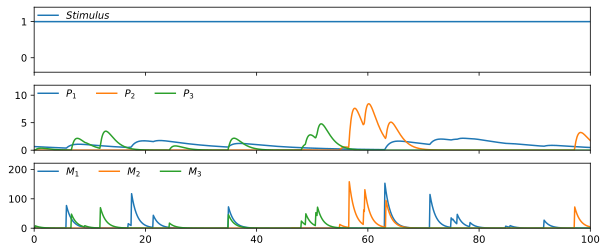

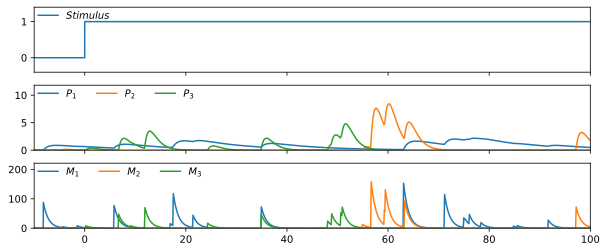

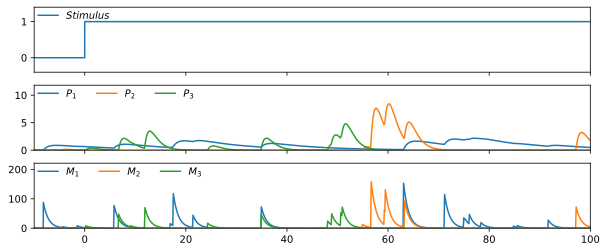

In [10]:
sim_burn_in = model.simulate(
    np.linspace(-10.0, 0.0, 1000, endpoint=False), 
    initial_state=np.zeros((2, model.n_genes_stim)),
    initial_time=-11.0
)

initial_state = sim_burn_in.final_state
# Activate Stimulus
initial_state[1, 0] = 1.0

# plot_simulation(sim_burn_in, True)
sim = model.simulate(
    time, 
    initial_state=initial_state, 
    initial_time=sim_burn_in.time_points[-1])
# plot_simulation(sim, True)

plot_simulation(sim_burn_in + sim, True).show(warn=False)
# sim_burn_in += sim
# plot_simulation(sim_burn_in, True).show(warn=False)